# Data Preprocessing



## 0. Install the omics_toolbox conda environment

If you have not already set up the `omics_toolbox` environment, you can create it using the provided `environment.yml` file. Use the following command in your terminal:

`conda env create -f environment.yml`

<a id='loading'></a>
## 1. Loading 10X data

### Downloading Data from Mendeley Datasets

The EB dataset is publically available as `scRNAseq.zip` at Mendelay Datasets at <https://data.mendeley.com/datasets/v6n743h5ng/>. 

Inside the scRNAseq folder, there are five subdirectories, and in each subdirectory are three files: `barcodes.tsv`, `genes.tsv`, and `matrix.mtx`. For more information about how CellRanger produces these files, check out the [Gene-Barcode Matrices Documentation](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/matrices).

Here's the directory structure:
```
data
└── raw
    └── scRNAseq
        ├── scRNAseq.zip
        ├── T0_1A
        │   ├── barcodes.tsv
        │   ├── genes.tsv
        │   └── matrix.mtx
        ├── T2_3B
        │   ├── barcodes.tsv
        │   ├── genes.tsv
        │   └── matrix.mtx
        ├── T4_5C
        │   ├── barcodes.tsv
        │   ├── genes.tsv
        │   └── matrix.mtx
        ├── T6_7D
        │   ├── barcodes.tsv
        │   ├── genes.tsv
        │   └── matrix.mtx
        └── T8_9E
            ├── barcodes.tsv
            ├── genes.tsv
            └── matrix.mtx
└── processed
└── interim
└── external
```

Make sure to download the files and save them under the `omics_toolbox/data/raw` directory.

In [ ]:
import os
RAW_DATA_DIR = os.path.join('../../data', 'raw')

print(RAW_DATA_DIR)

../../data/raw


### Using `scprep` to import data into Pandas DataFrames


We use a toolkit for loading and manipulating single-cell data called `scprep`. The function `load_10X` will automatically load 10X scRNAseq datasets (and others) into a Pandas DataFrame. DataFrames are incredibly useful tools for data analysis in Python. To learn more about them, [check out the Pandas Documentation and Tutorials](https://pandas.pydata.org/pandas-docs/stable/).


Let's load the data and create a single matrix that we can use for preprocessing, visualization, and analysis.

#### 1. Standard imports

In [2]:
import pandas as pd
import numpy as np
import phate
import scprep

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

#### 2. Use `scprep.io.load_10X` to import all three matrices into a DataFrame for each sample (this may take a few minutes)

Note: By default, `scprep.io.load_10X` loads scRNA-seq data using the Pandas SparseDataFrame [(**see Pandas docs**)](https://pandas.pydata.org/pandas-docs/stable/sparse.html) to maximize memory efficiency. However, this will be slower than loading on a dense matrix. To load a dense matrix, pass the `sparse=False` argument to `load_10X`. We use `gene_labels = 'both'` so we can see the gene symbols while still retaining the uniqueness offered by gene IDs.

In [ ]:
sparse=True
T1 = scprep.io.load_10X(os.path.join(RAW_DATA_DIR, "scRNAseq", "T0_1A"), sparse=sparse, gene_labels='both')
T2 = scprep.io.load_10X(os.path.join(RAW_DATA_DIR, "scRNAseq", "T2_3B"), sparse=sparse, gene_labels='both')
T3 = scprep.io.load_10X(os.path.join(RAW_DATA_DIR, "scRNAseq", "T4_5C"), sparse=sparse, gene_labels='both')
T4 = scprep.io.load_10X(os.path.join(RAW_DATA_DIR, "scRNAseq", "T6_7D"), sparse=sparse, gene_labels='both')
T5 = scprep.io.load_10X(os.path.join(RAW_DATA_DIR, "scRNAseq", "T8_9E"), sparse=sparse, gene_labels='both')
T1.head()

#### 3. Library size filtering 

We filter out cells that have either very large or very small library sizes. For this data set, library size correlates somewhat with sample and so we filter on a per-sample basis. In this case, we eliminate the top and bottom 20% of cells for each sample. Similar results are obtained with simpler, less conservative filtering.

/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='Library size', ylabel='Number of cells'>

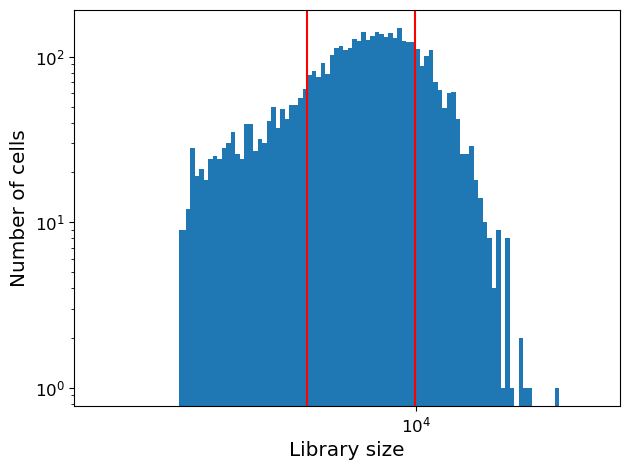

In [ ]:
scprep.plot.plot_library_size(T1, percentile=[20,80])

In [ ]:
filtered_batches = []
for batch in [T1, T2, T3, T4, T5]:
    batch = scprep.filter.filter_library_size(batch, percentile=20, keep_cells='above')
    batch = scprep.filter.filter_library_size(batch, percentile=80, keep_cells='below')
    filtered_batches.append(batch)
del T1, T2, T3, T4, T5 # removes objects from memory

#### 4. Merge all datasets and create a vector representing the time point of each sample

In this dataset, every single cell data is from a different timepoint. We will join it into a single large dataframe.

In [ ]:
EBT_counts, sample_labels = scprep.utils.combine_batches(
    filtered_batches, 
    ["Day 00-03", "Day 06-09", "Day 12-15", "Day 18-21", "Day 24-27"],
    append_to_cell_names=True
)
del filtered_batches # removes objects from memory
EBT_counts.head()


,A1BG (ENSG00000121410),A1BG-AS1 (ENSG00000268895),A1CF (ENSG00000148584),A2M (ENSG00000175899),A2M-AS1 (ENSG00000245105),A2ML1 (ENSG00000166535),A2ML1-AS1 (ENSG00000256661),A2ML1-AS2 (ENSG00000256904),A3GALT2 (ENSG00000184389),A4GALT (ENSG00000128274),...,ZXDC (ENSG00000070476),ZYG11A (ENSG00000203995),ZYG11B (ENSG00000162378),ZYX (ENSG00000159840),ZZEF1 (ENSG00000074755),ZZZ3 (ENSG00000036549),bP-21264C1.2 (ENSG00000278932),bP-2171C21.3 (ENSG00000279501),bP-2189O9.3 (ENSG00000279579),hsa-mir-1253 (ENSG00000272920)
AAACATACCAGAGG-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAAAGCA-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAAGTGA-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGGAGGTG-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGGTTTCT-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id='preprocessing'></a>
## 2. Preprocessing: Filtering, Normalizing, and Transforming

### Filtering

We filter the data by: 
1. Filtering by library size (if we did not do this prior to combining batches)
2. Removing genes that are expressed in relatively few cells.
3. Removing dead cells

We filter dead cells after library size normalization, since library size is not necessarily related to cell state.

** Filtering I: Library size filtering **

We did this before, because the library size correlated strongly with our samples. However, if we wanted to do something simplier, we could have run the following here instead:

`EBT_counts, sample_labels = scprep.filter.library_size_filter(EBT_counts, sample_labels, cutoff=2000)`

#### Filtering II: Remove rare genes

We eliminate genes that are expressed in 10 cells or fewer.

In [ ]:
EBT_counts = scprep.filter.filter_rare_genes(EBT_counts, min_cells=10)

### Normalization

To correct for differences in library sizes, we divide each cell by its library size and then rescale by the median library size.

In python this is performed using the preprocessing method `library_size_normalize()`.

In [ ]:
EBT_counts = scprep.normalize.library_size_normalize(EBT_counts)

#### Filtering III: Dead cell removal

Dead cells are likely to have a higher mitochondrial RNA expression level than live cells. Therefore, we remove suspected dead cells by eliminating cells that have the highest mitochondrial RNA expression levels on average.  

First let's look at the distribution of mitochontrial genes.

/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='Gene expression', ylabel='Number of cells'>

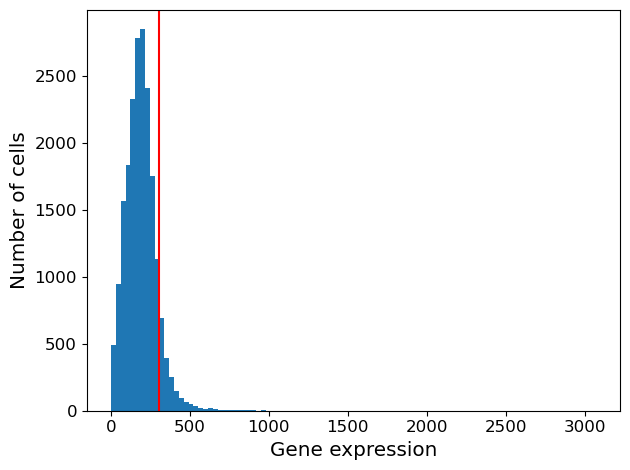

In [ ]:
mito_genes = scprep.select.get_gene_set(EBT_counts, starts_with="MT-") # Get all mitochondrial genes. There are 14, FYI.
scprep.plot.plot_gene_set_expression(EBT_counts, genes=mito_genes, percentile=90)

Here we see that above the top 90th percentile, there is a steep increase in expression of mitochondrial RNAs. We'll remove these cells from further analysis.

In [ ]:
EBT_counts, sample_labels = scprep.filter.filter_gene_set_expression(
    EBT_counts, sample_labels, genes=mito_genes, 
    percentile=90, keep_cells='below')

### Transformation

In scRNA-seq analysis, the data is often $\log$-transformed. This typically requires the addition of some small value to avoid taking $\log(0)$. We avoid this issue entirely by instead taking the square root transform. The square root function has a similar form as the $\log$ function with the added benefit of being stable at 0.

In [ ]:
EBT_counts = scprep.transform.sqrt(EBT_counts)

In [ ]:
EBT_counts

,A1BG (ENSG00000121410),A1BG-AS1 (ENSG00000268895),A2M (ENSG00000175899),A2M-AS1 (ENSG00000245105),A2ML1 (ENSG00000166535),A4GALT (ENSG00000128274),AAAS (ENSG00000094914),AACS (ENSG00000081760),AADAT (ENSG00000109576),AAED1 (ENSG00000158122),...,ZWILCH (ENSG00000174442),ZWINT (ENSG00000122952),ZXDA (ENSG00000198205),ZXDB (ENSG00000198455),ZXDC (ENSG00000070476),ZYG11A (ENSG00000203995),ZYG11B (ENSG00000162378),ZYX (ENSG00000159840),ZZEF1 (ENSG00000074755),ZZZ3 (ENSG00000036549)
AAACATTGAAGTGA-1_Day 00-03,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,1.413789,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AAACATTGGAGGTG-1_Day 00-03,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.988646,...,0.000000,1.712386,0.0,0.0,0.0,0.0,0.0,1.398157,0.0,0.0
AAACATTGGTTTCT-1_Day 00-03,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.981194,1.962388,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AAACCGTGCAGAAA-1_Day 00-03,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AAACGCACCGGTAT-1_Day 00-03,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,1.022861,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCTACTCTGATG-1_Day 24-27,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
TTTCTACTCTTATC-1_Day 24-27,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,2.019069,0.000000,...,2.019069,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
TTTCTACTTGAGCT-1_Day 24-27,2.071677,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
TTTGCATGATGACC-1_Day 24-27,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


<a id='anndata'></a>
# 3. Creating the AnnData objects

MIOFlow uses AnnData objects to handle the data. 
In the end, we need to create a _.h5ad_ that contains:
- gene values on _X_ (adata.X)
- phate embeddings of the data on _obsm_ (ex.: adata.obsm['X_phate])
- any extra metadata on _obs_ (ex.: adata.obs['time'], adata.obs['disease_progression'], etc...)

For this, we need to retrieve the metadata. 

In our case, the time points we saved as a DataFrame when joining all the dataset (under the sample_labels object)

For this data we don't have other labels, but they could have been added here.


In [ ]:
obs_df = pd.DataFrame({
    'time_label': sample_labels,
    # 'cell_class': cell_class,
    # 'cell_cycle_label' : cell_cycle_label
})
obs_df.head()

,time_label
AAACATTGAAGTGA-1_Day 00-03,Day 00-03
AAACATTGGAGGTG-1_Day 00-03,Day 00-03
AAACATTGGTTTCT-1_Day 00-03,Day 00-03
AAACCGTGCAGAAA-1_Day 00-03,Day 00-03
AAACGCACCGGTAT-1_Day 00-03,Day 00-03


#### Saving the object

In [ ]:
import scanpy as sc
adata = sc.AnnData(X=EBT_counts,obs=obs_df)

In [ ]:
PROCESSED_DATA_DIR = os.path.join('../../data', 'processed')

adata.write(os.path.join(PROCESSED_DATA_DIR, 'adata.h5ad'))